In [12]:
import torch
from torch.utils.data import DataLoader

from torchvision import datasets
import torchvision.transforms as transforms


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

from torchvision.utils import save_image

In [13]:
import os
from os import listdir

In [14]:
BASE_PATH_DATA = '../data/'

In [15]:
n_epochs = 10
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
img_size = 28
channels = 1

log_interval = 100


z_size = 20

In [16]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")

In [17]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        BASE_PATH_DATA + '/mnist/train',
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor()]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)


test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        BASE_PATH_DATA + '/mnist/test', 
        train=False, 
        download = True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor()]
        )
    ),
    batch_size=batch_size, shuffle=True
)

In [7]:
for i, (imgs, _) in enumerate(train_loader):
    print(imgs.view(64, -1).shape)
    break

torch.Size([64, 784])


Create VAE Class

In [8]:
class VAE(nn.Module):
    def __init__(self, hidden_layer_size, z_size):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, hidden_layer_size)
        self.fc21 = nn.Linear(hidden_layer_size, z_size)
        self.fc22 = nn.Linear(hidden_layer_size, z_size)
        self.fc3 = nn.Linear(z_size, hidden_layer_size)
        self.fc4 = nn.Linear(hidden_layer_size, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [48]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [10]:
def train(model, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [11]:
def test(model, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         '../data/first_test_results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [12]:
model = VAE(400, 20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas = (b1,b2))

In [13]:
for epoch in range(1, n_epochs + 1):
        train(model, epoch)
        test(model, epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       '../data/first_test_results/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 549.899109
Train Epoch: 1 [6400/60000 (11%)]	Loss: 232.273758
Train Epoch: 1 [12800/60000 (21%)]	Loss: 216.937256
Train Epoch: 1 [19200/60000 (32%)]	Loss: 185.842010
Train Epoch: 1 [25600/60000 (43%)]	Loss: 173.044464
Train Epoch: 1 [32000/60000 (53%)]	Loss: 162.104416
Train Epoch: 1 [38400/60000 (64%)]	Loss: 157.920715
Train Epoch: 1 [44800/60000 (75%)]	Loss: 154.271851
Train Epoch: 1 [51200/60000 (85%)]	Loss: 159.920441
Train Epoch: 1 [57600/60000 (96%)]	Loss: 151.986801
====> Epoch: 1 Average loss: 189.1177
====> Test set loss: 146.2478
Train Epoch: 2 [0/60000 (0%)]	Loss: 148.430496
Train Epoch: 2 [6400/60000 (11%)]	Loss: 142.440918
Train Epoch: 2 [12800/60000 (21%)]	Loss: 147.284546
Train Epoch: 2 [19200/60000 (32%)]	Loss: 135.962860
Train Epoch: 2 [25600/60000 (43%)]	Loss: 137.306427
Train Epoch: 2 [32000/60000 (53%)]	Loss: 133.011887
Train Epoch: 2 [38400/60000 (64%)]	Loss: 137.823700
Train Epoch: 2 [44800/60000 (75%)]	Loss: 129.961212
Train Ep

Train Epoch: 15 [6400/60000 (11%)]	Loss: 110.580002
Train Epoch: 15 [12800/60000 (21%)]	Loss: 104.176094
Train Epoch: 15 [19200/60000 (32%)]	Loss: 109.173622
Train Epoch: 15 [25600/60000 (43%)]	Loss: 113.009750
Train Epoch: 15 [32000/60000 (53%)]	Loss: 103.355576
Train Epoch: 15 [38400/60000 (64%)]	Loss: 103.198006
Train Epoch: 15 [44800/60000 (75%)]	Loss: 106.284203
Train Epoch: 15 [51200/60000 (85%)]	Loss: 104.065674
Train Epoch: 15 [57600/60000 (96%)]	Loss: 107.116760
====> Epoch: 15 Average loss: 107.5404
====> Test set loss: 106.8031
Train Epoch: 16 [0/60000 (0%)]	Loss: 106.903709
Train Epoch: 16 [6400/60000 (11%)]	Loss: 109.010292
Train Epoch: 16 [12800/60000 (21%)]	Loss: 109.700287
Train Epoch: 16 [19200/60000 (32%)]	Loss: 106.086975
Train Epoch: 16 [25600/60000 (43%)]	Loss: 106.148499
Train Epoch: 16 [32000/60000 (53%)]	Loss: 106.293884
Train Epoch: 16 [38400/60000 (64%)]	Loss: 104.195129
Train Epoch: 16 [44800/60000 (75%)]	Loss: 108.470291
Train Epoch: 16 [51200/60000 (85%)]	L

In [14]:
torch.save(model.state_dict(), BASE_PATH_DATA + "../data/models/first_try/no_norm.pt")


In [15]:
selection_layer = model.fc1.weight.detach().clone().numpy()
abs_selection_layer = np.abs(selection_layer)
l1_norm_each_column = np.apply_along_axis(sum, 0, abs_selection_layer)

In [16]:
l1_norm_each_column

array([ 7.16928223,  6.79531663,  7.04835737,  7.52466378,  7.03603591,
        7.23565822,  7.33732005,  7.10005973,  7.25097034,  7.06094152,
        7.078739  ,  7.22324464,  8.57032475,  8.53857566,  8.41128401,
        8.27567321,  7.4529977 ,  7.32203708,  6.9548209 ,  7.14029472,
        6.96818907,  7.47996694,  6.93000132,  7.06859413,  7.12124071,
        7.40462647,  7.30687544,  7.13479727,  7.47113119,  7.01731506,
        7.03029225,  6.9724107 ,  8.62737831,  9.56051702,  9.13327907,
       10.82679726,  9.75390516, 10.20154518, 11.11397037, 10.99861551,
       11.58842038, 12.51114525, 11.63198051, 11.70973964, 12.17519625,
       11.04525674, 11.83737912, 10.94167665, 10.06003396,  9.99716537,
        9.90048197,  9.96999168,  6.70643645,  7.43420202,  7.16658263,
        7.32094636,  7.28066298,  7.16297664,  8.92313802,  9.70706975,
       11.38708763, 12.89792362, 11.43264899, 14.12573355, 11.78248592,
       12.17685827, 12.3706413 , 12.27785661, 12.61130308, 11.96

# L1 Norm with an extra layer

In [17]:
class VAE_l1(nn.Module):
    def __init__(self, hidden_layer_size, z_size):
        super(VAE_l1, self).__init__()
        
        self.l1_clip_layer = nn.Linear(784, 784, bias = False)
        self.fc1 = nn.Linear(784, hidden_layer_size)
        self.fc21 = nn.Linear(hidden_layer_size, z_size)
        self.fc22 = nn.Linear(hidden_layer_size, z_size)
        self.fc3 = nn.Linear(z_size, hidden_layer_size)
        self.fc4 = nn.Linear(hidden_layer_size, 784)

    def encode(self, x):
        h0 = self.l1_clip_layer(x)
        h1 = F.relu(self.fc1(h0))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [18]:
model_l1_clip = VAE_l1(400, 20).to(device)

l1_norm = np.linalg.norm(model_l1_clip.l1_clip_layer.weight.detach().clone().numpy(), ord=1)
model_l1_clip.l1_clip_layer.weight = torch.nn.Parameter(model_l1_clip.l1_clip_layer.weight / l1_norm)
    
optimizer = torch.optim.Adam(model_l1_clip.parameters(), lr=lr, betas = (b1,b2))

In [19]:
def train_clip_weight(model, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        l1_norm = np.linalg.norm(model.l1_clip_layer.weight.detach().clone().numpy(), ord=1)
        model.l1_clip_layer.weight = torch.nn.Parameter(model.l1_clip_layer.weight / l1_norm)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
            

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [20]:
def test(model, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         '../data/first_test_results_l1_norm_extra_layer/reconstruction_' + 
                           str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [21]:
for epoch in range(1, n_epochs + 1):
        train_clip_weight(model_l1_clip, epoch)
        test(model_l1_clip, epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       '../data/first_test_results_l1_norm_extra_layer/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 550.024780
Train Epoch: 1 [6400/60000 (11%)]	Loss: 232.441010
Train Epoch: 1 [12800/60000 (21%)]	Loss: 218.676849
Train Epoch: 1 [19200/60000 (32%)]	Loss: 223.276184
Train Epoch: 1 [25600/60000 (43%)]	Loss: 217.332779
Train Epoch: 1 [32000/60000 (53%)]	Loss: 207.934830
Train Epoch: 1 [38400/60000 (64%)]	Loss: 207.903534
Train Epoch: 1 [44800/60000 (75%)]	Loss: 208.782837
Train Epoch: 1 [51200/60000 (85%)]	Loss: 191.576874
Train Epoch: 1 [57600/60000 (96%)]	Loss: 200.293961
====> Epoch: 1 Average loss: 221.3336
====> Test set loss: 194.4671
Train Epoch: 2 [0/60000 (0%)]	Loss: 191.051834
Train Epoch: 2 [6400/60000 (11%)]	Loss: 195.473236
Train Epoch: 2 [12800/60000 (21%)]	Loss: 197.087112
Train Epoch: 2 [19200/60000 (32%)]	Loss: 192.325607
Train Epoch: 2 [25600/60000 (43%)]	Loss: 194.291702
Train Epoch: 2 [32000/60000 (53%)]	Loss: 192.360519
Train Epoch: 2 [38400/60000 (64%)]	Loss: 180.752930
Train Epoch: 2 [44800/60000 (75%)]	Loss: 185.606796
Train Ep

Train Epoch: 15 [6400/60000 (11%)]	Loss: 120.001701
Train Epoch: 15 [12800/60000 (21%)]	Loss: 119.543190
Train Epoch: 15 [19200/60000 (32%)]	Loss: 114.506714
Train Epoch: 15 [25600/60000 (43%)]	Loss: 124.427155
Train Epoch: 15 [32000/60000 (53%)]	Loss: 122.071037
Train Epoch: 15 [38400/60000 (64%)]	Loss: 115.796143
Train Epoch: 15 [44800/60000 (75%)]	Loss: 121.298340
Train Epoch: 15 [51200/60000 (85%)]	Loss: 128.231949
Train Epoch: 15 [57600/60000 (96%)]	Loss: 120.705811
====> Epoch: 15 Average loss: 119.3840
====> Test set loss: 117.9141
Train Epoch: 16 [0/60000 (0%)]	Loss: 115.340256
Train Epoch: 16 [6400/60000 (11%)]	Loss: 119.855743
Train Epoch: 16 [12800/60000 (21%)]	Loss: 121.681366
Train Epoch: 16 [19200/60000 (32%)]	Loss: 113.947479
Train Epoch: 16 [25600/60000 (43%)]	Loss: 118.920601
Train Epoch: 16 [32000/60000 (53%)]	Loss: 131.010513
Train Epoch: 16 [38400/60000 (64%)]	Loss: 118.651962
Train Epoch: 16 [44800/60000 (75%)]	Loss: 118.206787
Train Epoch: 16 [51200/60000 (85%)]	L

In [22]:
torch.save(model_l1_clip.state_dict(), BASE_PATH_DATA + "../data/models/first_try/with_norm_extra_layer.pt")

In [23]:
l1_norm = np.linalg.norm(model_l1_clip.l1_clip_layer.weight.detach().clone().numpy(), ord=1)


In [24]:
l1_norm

0.99999976

In [25]:
selection_layer = model_l1_clip.l1_clip_layer.weight.detach().clone().numpy()

In [26]:
abs_selection_layer = np.abs(selection_layer)

In [27]:
l1_norm_each_column = np.apply_along_axis(sum, 0, abs_selection_layer)

In [28]:
l1_norm_each_column[l1_norm_each_column > 0.99]

array([0.99958752, 0.99114071, 0.99352123, 0.99343291, 0.99315413,
       0.99029483, 0.99244394, 0.99312003, 0.99902319, 0.99087082,
       0.995436  , 0.99610161, 0.99089983, 0.99401757, 0.99071468,
       0.99165669, 0.99006348, 0.9928895 , 1.00000042])

In [29]:
l1_norm_each_column

array([0.96363839, 0.94277012, 0.92898385, 0.94791537, 0.97497246,
       0.94601693, 0.9271083 , 0.98082783, 0.9483509 , 0.95613437,
       0.99958752, 0.9690532 , 0.91838443, 0.99114071, 0.93684556,
       0.9661863 , 0.92152835, 0.93072117, 0.96490775, 0.91512867,
       0.93719633, 0.94837722, 0.92129787, 0.93845987, 0.91059505,
       0.94099315, 0.94274611, 0.91532886, 0.95414467, 0.96288287,
       0.9400504 , 0.9478958 , 0.92025725, 0.9422504 , 0.95795396,
       0.94663274, 0.93096003, 0.98378093, 0.92258021, 0.96402687,
       0.94444344, 0.93993438, 0.95652801, 0.89961878, 0.95106552,
       0.9334911 , 0.94041348, 0.97387813, 0.94015661, 0.97620439,
       0.93559095, 0.92863166, 0.91972933, 0.94992082, 0.96025307,
       0.9391986 , 0.94952587, 0.95019449, 0.96257972, 0.95784391,
       0.93014431, 0.94558953, 0.94124681, 0.91651581, 0.95430474,
       0.92792337, 0.94036961, 0.97166686, 0.90676528, 0.9564508 ,
       0.95715016, 0.92576259, 0.95855679, 0.94216327, 0.94009

# L1 Norm with no extra layer

In [30]:
def train_clip_weight(model, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        l1_norm = np.linalg.norm(model.fc1.weight.detach().clone().numpy(), ord=1)
        model.fc1.weight = torch.nn.Parameter(model.fc1.weight / l1_norm)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
            

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [31]:
model_l1_clip = VAE(400, 20).to(device)

l1_norm = np.linalg.norm(model_l1_clip.fc1.weight.detach().clone().numpy(), ord=1)
model_l1_clip.fc1.weight = torch.nn.Parameter(model_l1_clip.fc1.weight / l1_norm)
    
optimizer = torch.optim.Adam(model_l1_clip.parameters(), lr=lr, betas = (b1,b2))

In [32]:
def test(model, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         '../data/first_test_results_l1_norm_no_extra_layer/reconstruction_' + 
                           str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [33]:
for epoch in range(1, n_epochs + 1):
        train_clip_weight(model_l1_clip, epoch)
        test(model_l1_clip, epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       '../data/first_test_results_l1_norm_no_extra_layer/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 550.048279
Train Epoch: 1 [6400/60000 (11%)]	Loss: 253.677917
Train Epoch: 1 [12800/60000 (21%)]	Loss: 225.875015
Train Epoch: 1 [19200/60000 (32%)]	Loss: 215.630554
Train Epoch: 1 [25600/60000 (43%)]	Loss: 210.943649
Train Epoch: 1 [32000/60000 (53%)]	Loss: 206.674820
Train Epoch: 1 [38400/60000 (64%)]	Loss: 210.875839
Train Epoch: 1 [44800/60000 (75%)]	Loss: 219.844879
Train Epoch: 1 [51200/60000 (85%)]	Loss: 204.992157
Train Epoch: 1 [57600/60000 (96%)]	Loss: 201.706650
====> Epoch: 1 Average loss: 230.5469
====> Test set loss: 207.5712
Train Epoch: 2 [0/60000 (0%)]	Loss: 206.770554
Train Epoch: 2 [6400/60000 (11%)]	Loss: 211.870331
Train Epoch: 2 [12800/60000 (21%)]	Loss: 208.397110
Train Epoch: 2 [19200/60000 (32%)]	Loss: 211.528412
Train Epoch: 2 [25600/60000 (43%)]	Loss: 198.429214
Train Epoch: 2 [32000/60000 (53%)]	Loss: 193.665405
Train Epoch: 2 [38400/60000 (64%)]	Loss: 211.422195
Train Epoch: 2 [44800/60000 (75%)]	Loss: 194.758896
Train Ep

Train Epoch: 15 [6400/60000 (11%)]	Loss: 126.751114
Train Epoch: 15 [12800/60000 (21%)]	Loss: 137.441971
Train Epoch: 15 [19200/60000 (32%)]	Loss: 136.163879
Train Epoch: 15 [25600/60000 (43%)]	Loss: 131.694992
Train Epoch: 15 [32000/60000 (53%)]	Loss: 133.560043
Train Epoch: 15 [38400/60000 (64%)]	Loss: 127.935623
Train Epoch: 15 [44800/60000 (75%)]	Loss: 132.007294
Train Epoch: 15 [51200/60000 (85%)]	Loss: 128.458023
Train Epoch: 15 [57600/60000 (96%)]	Loss: 133.797791
====> Epoch: 15 Average loss: 132.8495
====> Test set loss: 130.9870
Train Epoch: 16 [0/60000 (0%)]	Loss: 127.130035
Train Epoch: 16 [6400/60000 (11%)]	Loss: 128.866852
Train Epoch: 16 [12800/60000 (21%)]	Loss: 134.257416
Train Epoch: 16 [19200/60000 (32%)]	Loss: 127.036148
Train Epoch: 16 [25600/60000 (43%)]	Loss: 139.577225
Train Epoch: 16 [32000/60000 (53%)]	Loss: 143.420105
Train Epoch: 16 [38400/60000 (64%)]	Loss: 131.121948
Train Epoch: 16 [44800/60000 (75%)]	Loss: 139.882004
Train Epoch: 16 [51200/60000 (85%)]	L

In [34]:
torch.save(model_l1_clip.state_dict(), BASE_PATH_DATA + "../data/models/first_try/with_norm_no_extra_layer.pt")

In [35]:
selection_layer = model_l1_clip.fc1.weight.detach().clone().numpy()

In [36]:
abs_selection_layer = np.abs(selection_layer)

In [37]:
l1_norm_each_column = np.apply_along_axis(sum, 0, abs_selection_layer)

In [38]:
l1_norm_each_column

array([0.88263911, 0.9069716 , 0.94035317, 0.95554182, 0.92194361,
       0.92753977, 0.91475894, 0.93628588, 0.93750909, 0.90349619,
       0.90528965, 0.98850023, 0.89126152, 0.88007821, 0.85963397,
       0.89675208, 0.86876468, 0.90588691, 0.91891894, 0.9707311 ,
       0.92667354, 0.90813464, 0.93753976, 0.91275767, 0.90759018,
       0.94160638, 0.88998179, 0.92786227, 0.93633731, 0.89500375,
       0.91942608, 0.84941216, 0.93089064, 0.91893064, 0.93966949,
       0.85505713, 0.90391677, 0.90449732, 0.92599324, 0.89539913,
       0.93892315, 0.89727228, 0.93386219, 0.9375714 , 0.92146765,
       0.93503228, 0.88995671, 0.89624714, 0.93806094, 0.93276455,
       0.89602345, 0.91047644, 0.90502183, 0.89641111, 0.9100012 ,
       0.91426379, 0.87865201, 0.88050088, 0.8888116 , 0.91856039,
       0.91922711, 0.92111592, 0.88764808, 0.88302815, 0.92497973,
       0.89357756, 0.8756083 , 0.90828206, 0.90160484, 0.90677957,
       0.89944031, 0.87905926, 0.88349854, 0.90633766, 0.87332

# Vanilla VAE but with L1 Objective added to Loss

In [39]:
def train_l1_added(model, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        l1_norm = torch.norm(model.fc1.weight, p=1)
        loss += l1_norm
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [40]:
def test(model, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         '../data/first_test_results_l1_on_loss/reconstruction_' + 
                           str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [41]:
model = VAE(400, 20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas = (b1,b2))

In [42]:
for epoch in range(1, n_epochs + 1):
        train_l1_added(model, epoch)
        test(model, epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       '../data/first_test_results_l1_on_loss/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 633.786499
Train Epoch: 1 [6400/60000 (11%)]	Loss: 270.558197
Train Epoch: 1 [12800/60000 (21%)]	Loss: 236.259842
Train Epoch: 1 [19200/60000 (32%)]	Loss: 204.894302
Train Epoch: 1 [25600/60000 (43%)]	Loss: 193.383209
Train Epoch: 1 [32000/60000 (53%)]	Loss: 184.348450
Train Epoch: 1 [38400/60000 (64%)]	Loss: 172.598236
Train Epoch: 1 [44800/60000 (75%)]	Loss: 178.443192
Train Epoch: 1 [51200/60000 (85%)]	Loss: 161.810699
Train Epoch: 1 [57600/60000 (96%)]	Loss: 166.633469
====> Epoch: 1 Average loss: 211.5114
====> Test set loss: 158.2329
Train Epoch: 2 [0/60000 (0%)]	Loss: 168.217041
Train Epoch: 2 [6400/60000 (11%)]	Loss: 152.905609
Train Epoch: 2 [12800/60000 (21%)]	Loss: 159.634338
Train Epoch: 2 [19200/60000 (32%)]	Loss: 149.701324
Train Epoch: 2 [25600/60000 (43%)]	Loss: 153.751785
Train Epoch: 2 [32000/60000 (53%)]	Loss: 146.476013
Train Epoch: 2 [38400/60000 (64%)]	Loss: 154.076920
Train Epoch: 2 [44800/60000 (75%)]	Loss: 151.283020
Train Ep

Train Epoch: 15 [6400/60000 (11%)]	Loss: 119.231621
Train Epoch: 15 [12800/60000 (21%)]	Loss: 115.029831
Train Epoch: 15 [19200/60000 (32%)]	Loss: 113.881554
Train Epoch: 15 [25600/60000 (43%)]	Loss: 114.487076
Train Epoch: 15 [32000/60000 (53%)]	Loss: 117.106445
Train Epoch: 15 [38400/60000 (64%)]	Loss: 115.038170
Train Epoch: 15 [44800/60000 (75%)]	Loss: 119.269638
Train Epoch: 15 [51200/60000 (85%)]	Loss: 117.066551
Train Epoch: 15 [57600/60000 (96%)]	Loss: 112.625824
====> Epoch: 15 Average loss: 116.0230
====> Test set loss: 110.9871
Train Epoch: 16 [0/60000 (0%)]	Loss: 121.704185
Train Epoch: 16 [6400/60000 (11%)]	Loss: 115.088326
Train Epoch: 16 [12800/60000 (21%)]	Loss: 116.009041
Train Epoch: 16 [19200/60000 (32%)]	Loss: 120.474525
Train Epoch: 16 [25600/60000 (43%)]	Loss: 120.396629
Train Epoch: 16 [32000/60000 (53%)]	Loss: 106.680809
Train Epoch: 16 [38400/60000 (64%)]	Loss: 119.237419
Train Epoch: 16 [44800/60000 (75%)]	Loss: 120.691338
Train Epoch: 16 [51200/60000 (85%)]	L

In [43]:
torch.save(model.state_dict(), BASE_PATH_DATA + "../data/models/first_try/no_extra_layer_l1_obj.pt")

In [44]:
selection_layer = model.fc1.weight.detach().clone().numpy()
abs_selection_layer = np.abs(selection_layer)
l1_norm_each_column = np.apply_along_axis(sum, 0, abs_selection_layer)

In [45]:
l1_norm_each_column

array([0.02015531, 0.02073321, 0.0202737 , 0.02091513, 0.02082473,
       0.02232557, 0.02086559, 0.02045751, 0.02010764, 0.02137731,
       0.02129521, 0.02181275, 0.02128266, 0.02253216, 0.02104544,
       0.01926024, 0.0207461 , 0.02033219, 0.02171256, 0.0196468 ,
       0.02255907, 0.02064506, 0.02192439, 0.0202828 , 0.02202513,
       0.02042202, 0.01988448, 0.02178324, 0.02123541, 0.02149822,
       0.02211182, 0.0208573 , 0.01930092, 0.01954004, 0.02086005,
       0.01902962, 0.02004075, 0.01979182, 0.01903752, 0.01946038,
       0.04180263, 0.02985107, 0.02376955, 0.02823694, 0.01865218,
       0.01907529, 0.02003133, 0.02418498, 0.01993056, 0.02172282,
       0.02118365, 0.02044112, 0.02016383, 0.02048921, 0.0215823 ,
       0.02140343, 0.02232104, 0.02134913, 0.02051459, 0.01981056,
       0.02039936, 0.01949201, 0.01927872, 0.06018926, 0.01901491,
       0.01631769, 0.02907819, 0.04779673, 0.05318206, 0.06342205,
       0.09382545, 0.15371182, 0.08678072, 0.09449939, 0.13401

# L1 Diag

In [77]:
class VAE_l1_diag(nn.Module):
    def __init__(self, hidden_layer_size, z_size):
        super(VAE_l1_diag, self).__init__()
        
        self.diag = torch.normal(torch.zeros(784), torch.ones(784)).clone().detach().requires_grad_(True)
        self.selection_layer = torch.diag(self.diag)
        self.fc1 = nn.Linear(784, hidden_layer_size)
        self.fc21 = nn.Linear(hidden_layer_size, z_size)
        self.fc22 = nn.Linear(hidden_layer_size, z_size)
        self.fc3 = nn.Linear(z_size, hidden_layer_size)
        self.fc4 = nn.Linear(hidden_layer_size, 784)

    def encode(self, x):
        h0 = torch.mm(x, self.selection_layer)
        h1 = F.relu(self.fc1(h0))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [78]:
def train_l1_added(model, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        l1_norm = 10 * torch.norm(model.diag, p=1)
        loss += l1_norm
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [79]:
def test(model, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         '../data/first_test_results_l1_on_loss_diag/reconstruction_' + 
                           str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [80]:
model = VAE_l1_diag(400, 20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas = (b1,b2))

In [81]:
for epoch in range(1, n_epochs + 1):
        train_l1_added(model, epoch)
        test(model, epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       '../data/first_test_results_l1_on_loss_diag/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 644.795898
Train Epoch: 1 [6400/60000 (11%)]	Loss: 332.856140
Train Epoch: 1 [12800/60000 (21%)]	Loss: 304.049805
Train Epoch: 1 [19200/60000 (32%)]	Loss: 291.460541
Train Epoch: 1 [25600/60000 (43%)]	Loss: 274.381256
Train Epoch: 1 [32000/60000 (53%)]	Loss: 255.409866
Train Epoch: 1 [38400/60000 (64%)]	Loss: 268.645874
Train Epoch: 1 [44800/60000 (75%)]	Loss: 262.972595
Train Epoch: 1 [51200/60000 (85%)]	Loss: 255.126434
Train Epoch: 1 [57600/60000 (96%)]	Loss: 253.389923
====> Epoch: 1 Average loss: 286.7495
====> Test set loss: 150.1991
Train Epoch: 2 [0/60000 (0%)]	Loss: 243.030045
Train Epoch: 2 [6400/60000 (11%)]	Loss: 238.883652
Train Epoch: 2 [12800/60000 (21%)]	Loss: 239.931686
Train Epoch: 2 [19200/60000 (32%)]	Loss: 235.622330
Train Epoch: 2 [25600/60000 (43%)]	Loss: 234.030960
Train Epoch: 2 [32000/60000 (53%)]	Loss: 231.092621
Train Epoch: 2 [38400/60000 (64%)]	Loss: 223.840302
Train Epoch: 2 [44800/60000 (75%)]	Loss: 226.030304
Train Ep

Train Epoch: 15 [6400/60000 (11%)]	Loss: 205.791611
Train Epoch: 15 [12800/60000 (21%)]	Loss: 204.912384
Train Epoch: 15 [19200/60000 (32%)]	Loss: 206.347473
Train Epoch: 15 [25600/60000 (43%)]	Loss: 200.009705
Train Epoch: 15 [32000/60000 (53%)]	Loss: 203.163361
Train Epoch: 15 [38400/60000 (64%)]	Loss: 195.428101
Train Epoch: 15 [44800/60000 (75%)]	Loss: 203.810349
Train Epoch: 15 [51200/60000 (85%)]	Loss: 206.656281
Train Epoch: 15 [57600/60000 (96%)]	Loss: 199.066315
====> Epoch: 15 Average loss: 202.2496
====> Test set loss: 107.2704
Train Epoch: 16 [0/60000 (0%)]	Loss: 201.210739
Train Epoch: 16 [6400/60000 (11%)]	Loss: 203.779465
Train Epoch: 16 [12800/60000 (21%)]	Loss: 204.356201
Train Epoch: 16 [19200/60000 (32%)]	Loss: 202.558273
Train Epoch: 16 [25600/60000 (43%)]	Loss: 200.780380
Train Epoch: 16 [32000/60000 (53%)]	Loss: 202.588669
Train Epoch: 16 [38400/60000 (64%)]	Loss: 203.737610
Train Epoch: 16 [44800/60000 (75%)]	Loss: 199.732880
Train Epoch: 16 [51200/60000 (85%)]	L

In [82]:
torch.save(model.state_dict(), BASE_PATH_DATA + "../data/models/first_try/no_extra_layer_l1_diag.pt")

In [83]:
selection_layer = model.selection_layer.detach().clone().numpy()
abs_selection_layer = np.abs(selection_layer)
l1_norm_each_column = np.apply_along_axis(sum, 0, abs_selection_layer)

In [84]:
l1_norm_each_column

array([1.52356839e+00, 1.08170009e+00, 1.96719110e+00, 9.39557016e-01,
       8.39012146e-01, 1.11134028e+00, 8.19181204e-01, 1.62094057e+00,
       8.05505812e-02, 2.39829570e-01, 1.08921766e+00, 2.38948181e-01,
       1.29866993e+00, 1.65522806e-02, 1.34561896e+00, 3.72081578e-01,
       1.54987741e+00, 2.67038852e-01, 4.28588331e-01, 1.92137454e-02,
       5.28924108e-01, 3.08857154e-04, 8.42303813e-01, 1.37691545e+00,
       3.57276499e-02, 4.97702397e-02, 9.84163821e-01, 8.25465679e-01,
       1.10408321e-01, 5.36151648e-01, 2.50806427e+00, 1.92158327e-01,
       6.77519441e-01, 1.13175072e-01, 4.62892413e-01, 2.29048893e-01,
       2.34253854e-01, 3.63710761e-01, 2.96998501e-01, 4.15840358e-01,
       1.16567123e+00, 8.42772499e-02, 9.74053144e-01, 1.29100072e+00,
       4.46270168e-01, 1.52253795e+00, 1.24962282e+00, 9.04596567e-01,
       2.65812082e-03, 2.44100428e+00, 1.66805208e-01, 3.30642879e-01,
       9.63173509e-01, 1.00976694e+00, 5.38245678e-01, 1.90841243e-01,
      

In [85]:
selection_layer

array([[ 1.5235684 ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.0817001 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.9671911 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -2.012227  ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.13244244,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.48457873]], dtype=float32)

In [86]:
np.std(l1_norm_each_column)

0.585748870064744

In [87]:
import matplotlib.pyplot as plt

(array([239., 210., 156.,  91.,  54.,  21.,   7.,   3.,   2.,   1.]),
 array([3.08857154e-04, 3.82243084e-01, 7.64177311e-01, 1.14611154e+00,
        1.52804577e+00, 1.90997999e+00, 2.29191422e+00, 2.67384845e+00,
        3.05578267e+00, 3.43771690e+00, 3.81965113e+00]),
 <a list of 10 Patch objects>)

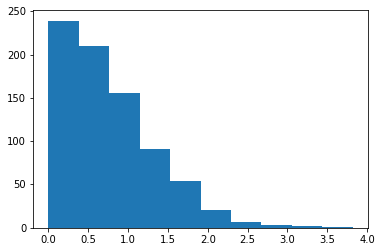

In [88]:
plt.hist(l1_norm_each_column)

<BarContainer object of 784 artists>

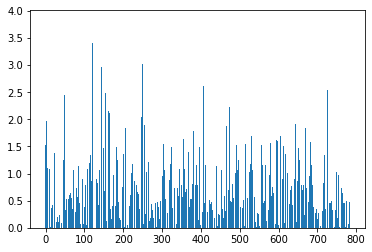

In [89]:
plt.bar(np.arange(len(l1_norm_each_column)),l1_norm_each_column)